In [1]:
import wandb

api = wandb.Api(timeout=19)
sweep = api.sweep('carla-pedestrians/sensitivity/sweeps/j7yihb85')

In [2]:
from pedestrians_scenarios.karma.pose.skeleton import CARLA_SKELETON
import pandas as pd

columns = pd.MultiIndex.from_tuples([('missing_joint_probabilities', k) for k in CARLA_SKELETON.__members__.keys()] + [('F1Score', 'summary'), ('F1Score', 'max')])

In [3]:
import os

if not os.path.exists('sensitivity_analysis.csv'):
    rows = []

    for run in sweep.runs:
        try:
            row = list(run.config['missing_joint_probabilities']) + [run.summary['hp/F1Score'], run.history()['hp/F1Score'].max()]
            rows.append(row)
        except:
            pass

    df = pd.DataFrame(rows, columns=columns)
    df.to_csv('sensitivity_analysis.csv')
else:
    df = pd.read_csv('sensitivity_analysis.csv', skiprows=2, names=columns)

In [4]:
df.head(10)

missing_joint_probabilities                                          \
                     crl_root crl_hips__C crl_spine__C crl_spine01__C   
0                           0           1            0              1   
1                           0           1            0              1   
2                           1           1            1              1   
3                           0           1            1              1   
4                           1           1            0              1   
5                           0           1            1              0   
6                           1           1            1              1   
7                           1           1            1              1   
8                           1           1            1              1   
9                           1           1            1              1   

                                                                     \
  crl_shoulder__L crl_arm__L crl_foreArm__L crl_hand__L crl_neck__C   
0               1          1              0           0           1   
1               0          0              0           1           1   
2               1          1              1           1           1   
3               1          0              0           1           1   
4               1          1              0           1           1   
5               0          1              1           0           1   
6               1          0              1           0           0   
7               1          0              1           1           1   
8               1          0              1           1           1   
9               1          0              0           1           1   

               ...                                                    \
  crl_Head__C  ... crl_foot__R crl_toe__R crl_toeEnd__R crl_thigh__L   
0           0  ...           1          1             1            1   
1           0  ...           0          1             0            1   
2           1  ...           0          1             1            1   
3           1  ...           1          1             1            1   
4           0  ...           1          0             0            1   
5           0  ...           1          1             1            1   
6           1  ...           0          1             1            1   
7           0  ...           1          1             1            0   
8           1  ...           1          1             0            0   
9           0  ...           1          1             0            0   

                                                    F1Score            
  crl_leg__L crl_foot__L crl_toe__L crl_toeEnd__L   summary       max  
0          1           1          1             0  0.797449  0.814322  
1          0           0          1             0  0.849567  0.858191  
2          0           1          1             1  0.751093  0.752303  
3          1           1          1             1  0.836981  0.839198  
4          1           1          0             1  0.849117  0.834394  
5          1           0          1             1  0.863285  0.779816  
6          1           1          1             1  0.830619  0.805755  
7          0           1          0             1  0.851706  0.835964  
8          0           1          0             0  0.843086  0.816020  
9          1           1          1             0  0.838858  0.849833  

[10 rows x 28 columns]

In [5]:
import numpy as np

joints = df.values[:, :-2]
f1score = df.values[:, -2:].max(axis=1).reshape(-1, 1)

X = np.concatenate((joints, f1score), axis=1)


In [6]:
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph

params = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params["n_neighbors"], include_self=False
)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
ward = cluster.AgglomerativeClustering(
    n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
)
spectral = cluster.SpectralClustering(
    n_clusters=params["n_clusters"],
    eigen_solver="arpack",
    affinity="nearest_neighbors",
)
dbscan = cluster.DBSCAN(eps=params["eps"])
optics = cluster.OPTICS(
    min_samples=params["min_samples"],
    xi=params["xi"],
    min_cluster_size=params["min_cluster_size"],
)
affinity_propagation = cluster.AffinityPropagation(
    damping=params["damping"], preference=params["preference"], random_state=0
)
average_linkage = cluster.AgglomerativeClustering(
    linkage="average",
    affinity="cityblock",
    n_clusters=params["n_clusters"],
    connectivity=connectivity,
)
birch = cluster.Birch(n_clusters=params["n_clusters"])
gmm = mixture.GaussianMixture(
    n_components=params["n_clusters"], covariance_type="full"
)

clustering_algorithms = (
    ("MiniBatch\nKMeans", two_means),
    ("Affinity\nPropagation", affinity_propagation),
    ("MeanShift", ms),
    ("Spectral\nClustering", spectral),
    ("Ward", ward),
    ("Agglomerative\nClustering", average_linkage),
    ("DBSCAN", dbscan),
    ("OPTICS", optics),
    ("BIRCH", birch),
    ("Gaussian\nMixture", gmm),
)

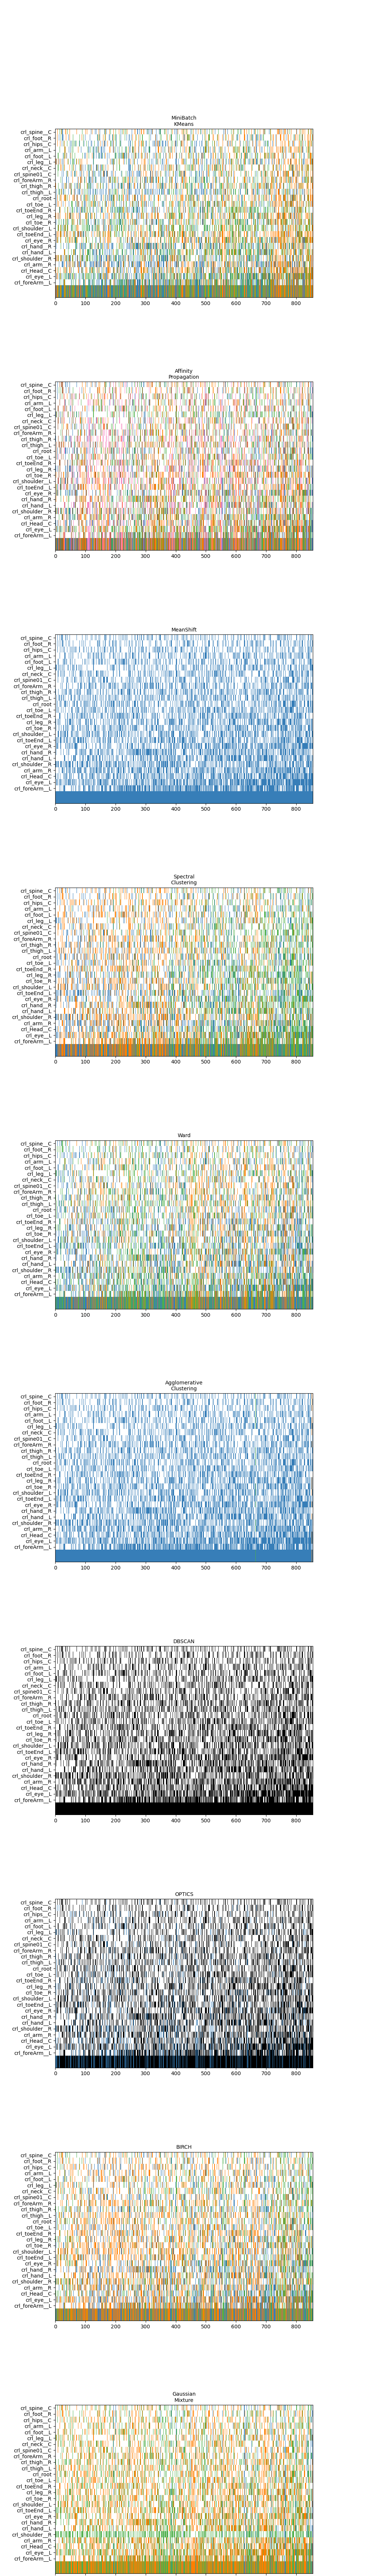

In [7]:
%matplotlib widget

from itertools import cycle, islice
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors

num_joints = len(joints[0])
sorted_f1score = np.argsort(f1score, axis=0)[:,0]
sorted_joints = np.argsort((1 - joints).sum(axis=0), axis=0)
joint_names = np.array(list(CARLA_SKELETON.__members__.keys()))[sorted_joints]

bar_width = 20
identification_width = 2

sorted_joints = np.concatenate((sorted_joints, np.arange(num_joints, num_joints + identification_width)))

plt.figure(figsize=(10, 70))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.5
)

for plot_num, (name, algorithm) in enumerate(clustering_algorithms):
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the "
            + "connectivity matrix is [0-9]{1,2}"
            + " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning,
        )
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, "labels_"):
        labels = algorithm.labels_.astype(int)
    else:
        labels = algorithm.predict(X)

    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        matplotlib.colors.to_rgb("#377eb8"),
                        matplotlib.colors.to_rgb("#ff7f00"),
                        matplotlib.colors.to_rgb("#4daf4a"),
                        matplotlib.colors.to_rgb("#f781bf"),
                        matplotlib.colors.to_rgb("#a65628"),
                        matplotlib.colors.to_rgb("#984ea3"),
                        matplotlib.colors.to_rgb("#999999"),
                        matplotlib.colors.to_rgb("#e41a1c"),
                        matplotlib.colors.to_rgb("#dede00"),
                    ]
                ),
                int(max(labels) + 1),
            )
        )
    )
    # add black color for outliers (if any)
    if len(colors):
        colors = np.vstack((colors, [matplotlib.colors.to_rgb("#000000")]))
    else:
        colors = np.array([matplotlib.colors.to_rgb("#000000")])

    img_colors = np.array([((*colors[labels[i]],),) for i in range(len(joints))])

    img = np.where(
        np.expand_dims(np.hstack((
            (joints == 0),
            ((True, ) * identification_width, ) * len(joints)
        )), 2),
        img_colors.repeat(num_joints + identification_width, axis=1),
        np.ones((len(joints), num_joints + identification_width, 3)),
    ).astype(np.float32)

    img_sorted = img[sorted_f1score][:,sorted_joints]
    img_sorted = img_sorted.repeat(bar_width, axis=1)
    img_sorted = img_sorted.transpose(1, 0, 2)

    plt.subplot(10, 1, plot_num+1)
    plt.title(name, size=10)
    plt.imshow(img_sorted, interpolation="none")
    plt.yticks(np.arange(bar_width/2, num_joints * bar_width + bar_width/2, bar_width), joint_names)

plt.show()